![Alt text](pic.png)

In [4]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

/var/folders/n_/7tqgdxqs259f7cnfxbsjqzwm0000gp/T/ipykernel_33847/2928325851.py:28: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


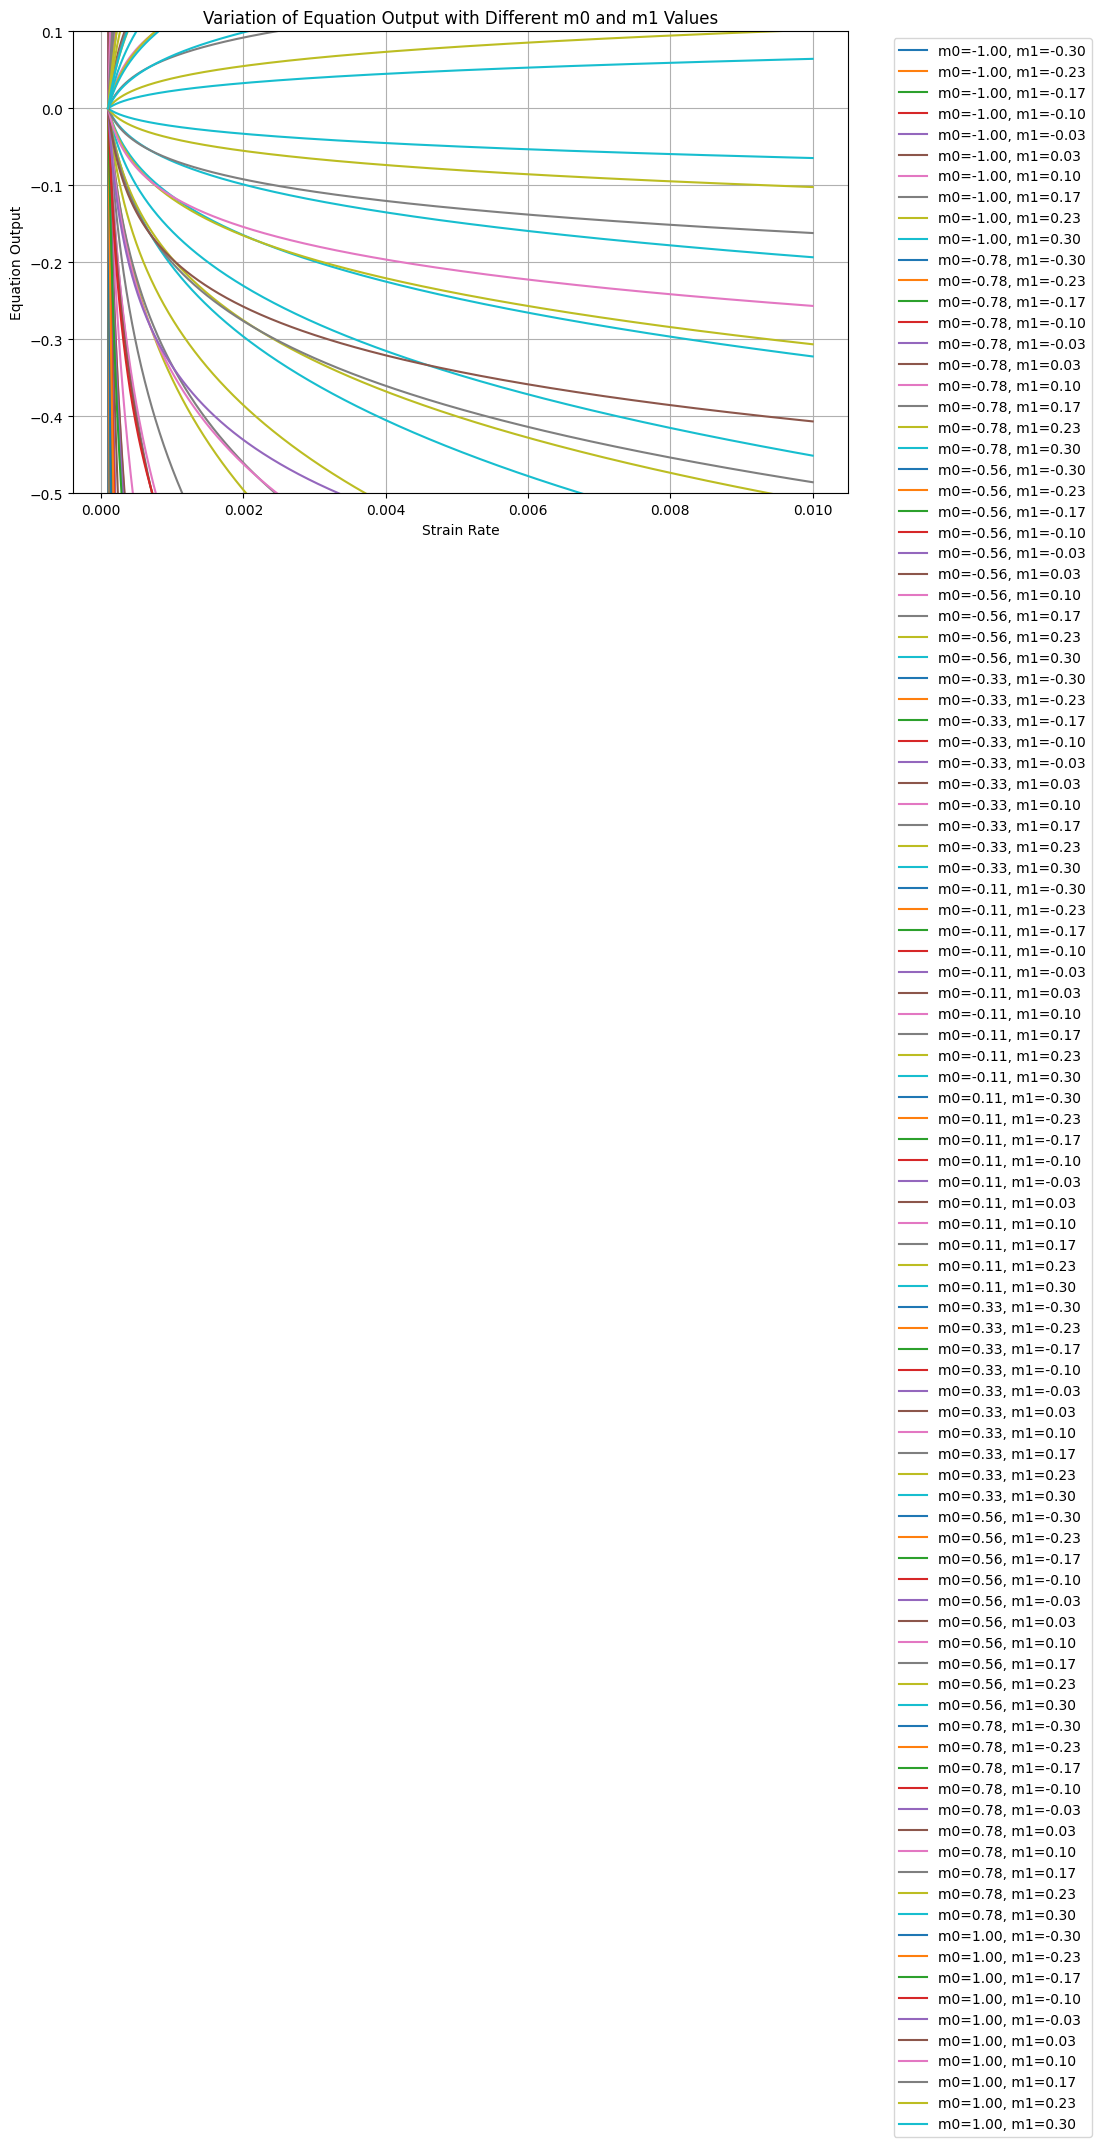

In [179]:
# Define strain rate values
strain_rate = np.linspace(0.0001, 0.01 , 1000)

# Define a range of m0 and m1 values
m0_values = np.linspace(-1, 1, 10)
m1_values = np.linspace(-0.3, 0.3, 10)

# Plot for different combinations of m0 and m1
plt.figure(figsize=(10, 6))
for m0 in m0_values:
    for m1 in m1_values:
        # Calculate the equation for each combination of m0 and m1
        result = m0 * (np.sqrt(strain_rate * 0.0001) ** m1) * (np.log(strain_rate / 0.0001))
        # Plot the result
        plt.title(f"m0={m0:.2f}, m1={m1:.2f}")
        plt.plot(strain_rate, result, label=f"m0={m0:.2f}, m1={m1:.2f}")

# Add labels and title
plt.xlabel("Strain Rate")
plt.ylabel("Equation Output")
plt.ylim(-0.5,0.1)
plt.title("Variation of Equation Output with Different m0 and m1 Values")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()


<function matplotlib.pyplot.show(close=None, block=None)>

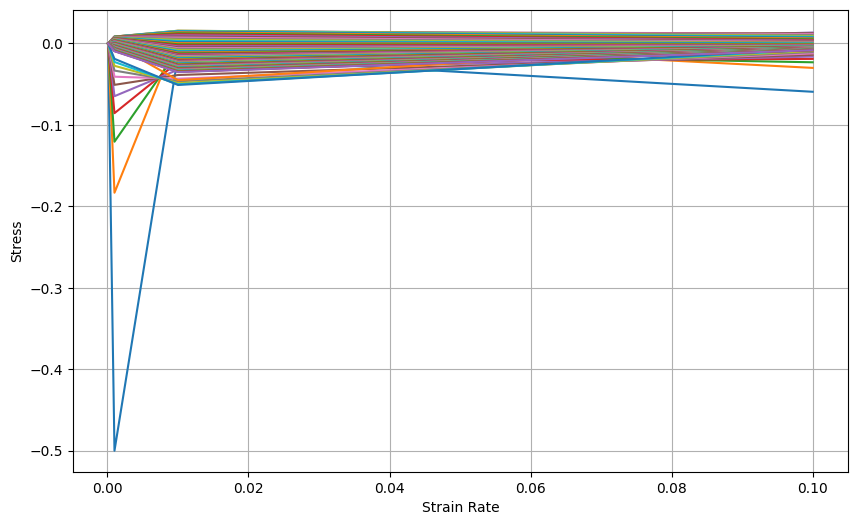

In [172]:
temp = '373.15'
strain_rates = np.array([0.0001, 0.001, 0.01, 0.1])
strain_rate_columns = ['ref_StrRt0.0001', 'ref_StrRt0.001', 'ref_StrRt0.01', 'ref_StrRt0.1']
data = pd.read_csv(f"../Tmp{temp}_RD.csv")

plt.figure(figsize=(10,6))
for i in range(len(data)):
    # Extract stress data for each row
    stress_values = np.log(data.iloc[i][strain_rate_columns][0:5].values)
    plt.plot(strain_rates[0:5], stress_values, '-', label='Data')
    plt.xlabel('Strain Rate')
    plt.ylabel('Stress')
    plt.grid()

plt.show

In [180]:
def wagoner(strain_rate, m0, m1):
    return m0 * (np.sqrt(strain_rate * 0.0001) ** m1) * (np.log(strain_rate / 0.0001))

def estimate_m_values(data, temp, strain_rates, strain_rate_columns, plot=True):
    """
    Fits strain rate dependency for each row in a dataset and exports results.
    
    Parameters:
    - temperature_file (str): Path to the CSV file containing the data for a specific temperature.
    - strain_rates (list of float): List of strain rate values corresponding to columns in the dataset.
    - strain_rate_columns (list of str): List of column names in the data corresponding to strain rates.
    
    Output:
    - CSV file with columns: PEEQ, m0, m1, R_squared for each row in the dataset.
    """

    # Default rows to plot
    plot_indices = [0,1,2,3,4]
    #3, 4, 5, 6, 11
    
    # Define a scaling factor for better readability in the plot legend
    scale_factor = 1

    # List to store the results
    results = []

    # Loop through all rows in the dataset for strain-rate dependency fitting
    for i in range(len(data)):
        # Extract stress data for each row
        stress_values = data.iloc[i][strain_rate_columns].values
        stress_values = np.log(stress_values)
        bounds =  [(-5,-5), (1000,1000)]
        
        initial_guess = [-1, 0.5]
        
        # Initial guess for m0 and m1
        if temp == '298.15': 
            initial_guess = [5, 1]
        elif temp == '373.15': 
            initial_guess = [1, 0.5]
        
        # Perform the curve fitting using wagoner function
        try:
            params, _ = curve_fit(wagoner, strain_rates, stress_values, p0=initial_guess, bounds=bounds, maxfev=100000)
        except RuntimeError:
            print(f"Could not fit strain-rate dependency for row {i}")
            continue
        
        # Calculate residuals and R-squared
        stress_fit = wagoner(np.array(strain_rates), *params)
        residuals = stress_values - stress_fit
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((stress_values - np.mean(stress_values))**2)
        r_squared = 1 - (ss_res / ss_tot)
        
        # Store results for exporting
        results.append({
            "PEEQ": data['strain'].iloc[i],
            "m0": params[0],
            "m1": params[1],
            "R_squared": r_squared
        })
        
        plt_strain_rates = np.linspace(min(strain_rates), max(strain_rates), 1000)
        plt_stress_fit = wagoner(plt_strain_rates, *params)
        # Plot only for specified rows with scaled m0 and m1 in legend
        if i in plot_indices:
            plt.plot(strain_rates, stress_values, 'o', label='Data')
            plt.plot(plt_strain_rates, plt_stress_fit, '-', label='Fit')
            plt.xlabel('Strain Rate')
            plt.ylabel('Stress')
            plt.title(f"Fit for Row {i} {temp}K (R² = {r_squared:.3f})")
            plt.legend([f'Row {i}', f'Fit: m0={params[0]:.2f}, m1={params[1]:.2f}'], loc="lower right")
            plt.grid()
            plt.show()

    # Export results to CSV
    df = pd.DataFrame(results)
    df.to_csv(f"w_m_values_{temp}.csv", index=False)

    if plot:
        strain = data['strain']
        for strain_rate, col in zip(strain_rates, strain_rate_columns):
            fitted_stress = [wagoner(strain_rate, m0, m1) for m0, m1 in zip(df['m0'], df['m1'])]
            real_stress = np.log(data[col].values)

            residuals = real_stress - fitted_stress
            ss_res = np.sum(residuals**2)
            ss_tot = np.sum((real_stress - np.mean(real_stress))**2)
            r_squared = 1 - (ss_res / ss_tot)
            
            plt.plot(strain, fitted_stress, label=f'Predicted StrRt{strain_rate}')
            plt.scatter(strain, real_stress, color='red', label=f'Real StrRt{strain_rate}')
            plt.xlabel('Strain')
            plt.ylabel('Normalized Stress')
            plt.title(f'Real vs Predicted Stress for StrRt{strain_rate} {temp}K  (R² = {r_squared:.3f})')
            plt.legend()
            plt.show()


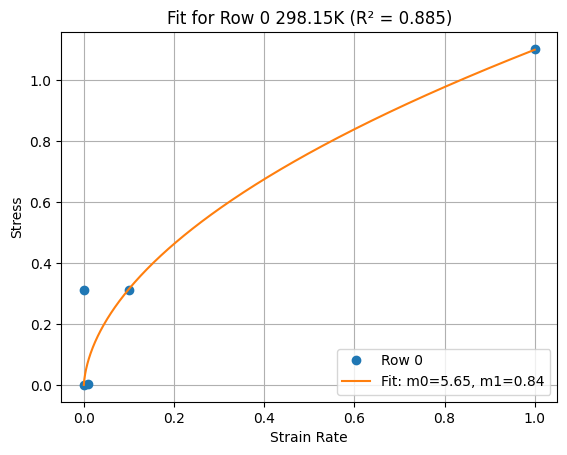

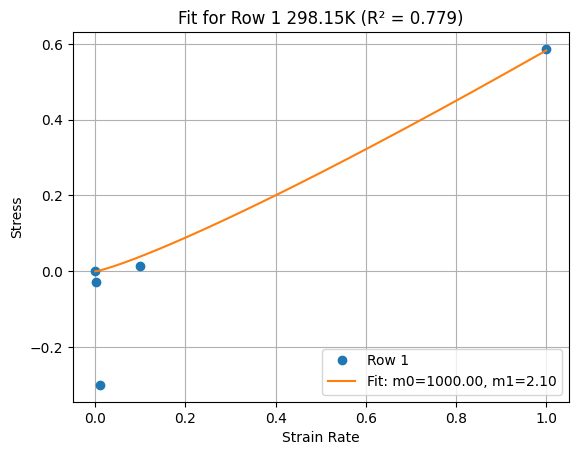

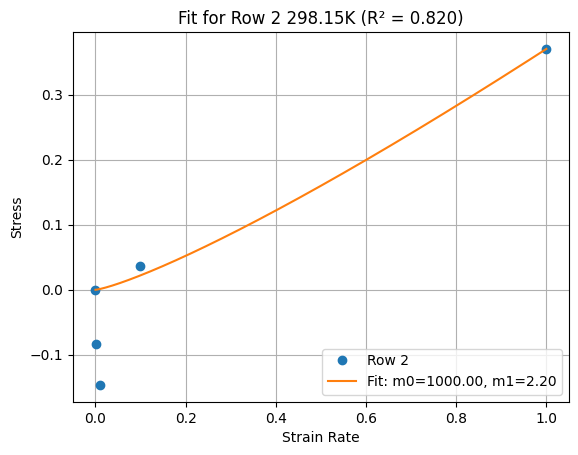

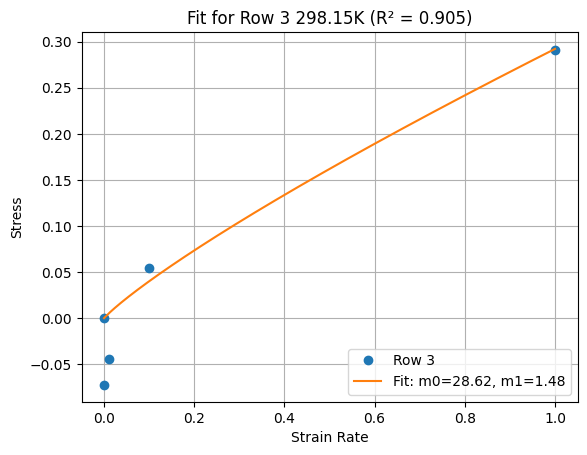

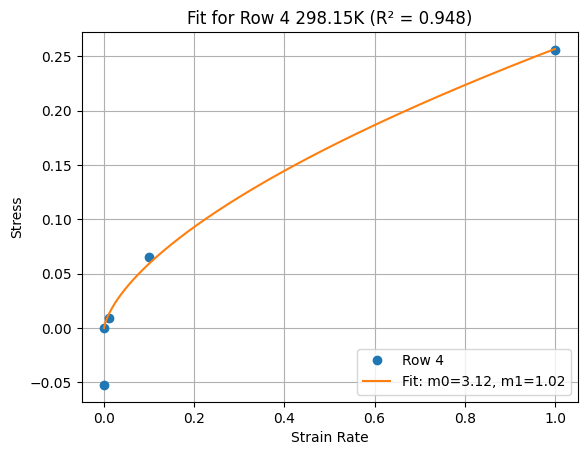

/var/folders/n_/7tqgdxqs259f7cnfxbsjqzwm0000gp/T/ipykernel_33847/2446139207.py:90: RuntimeWarning: invalid value encountered in scalar divide
  r_squared = 1 - (ss_res / ss_tot)


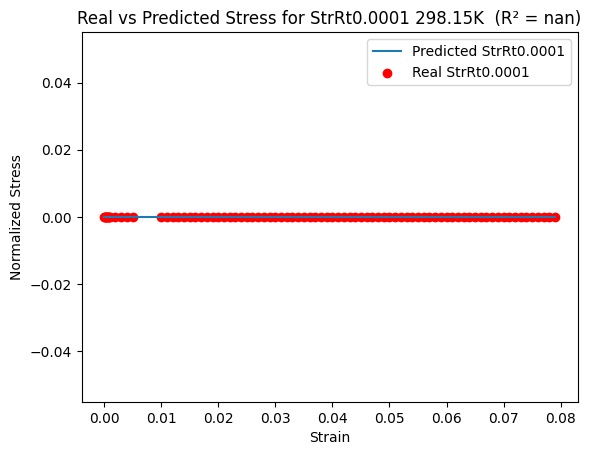

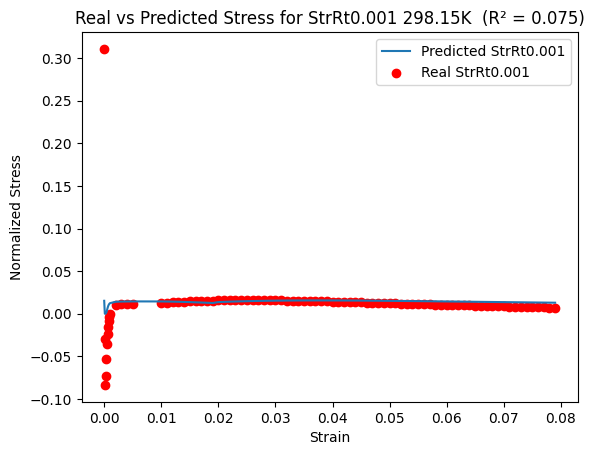

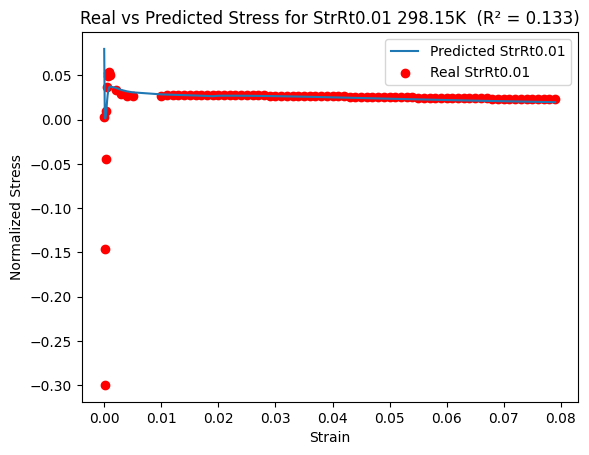

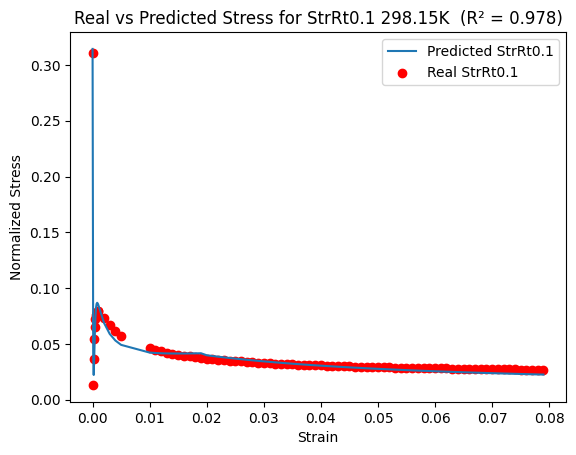

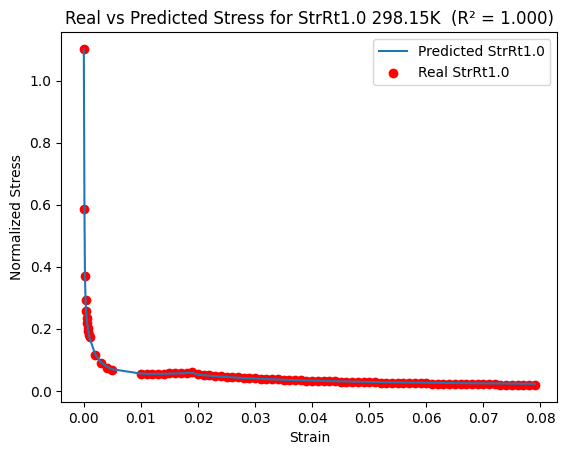

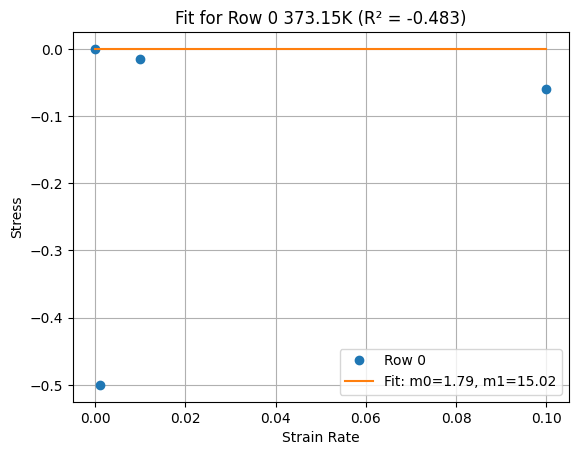

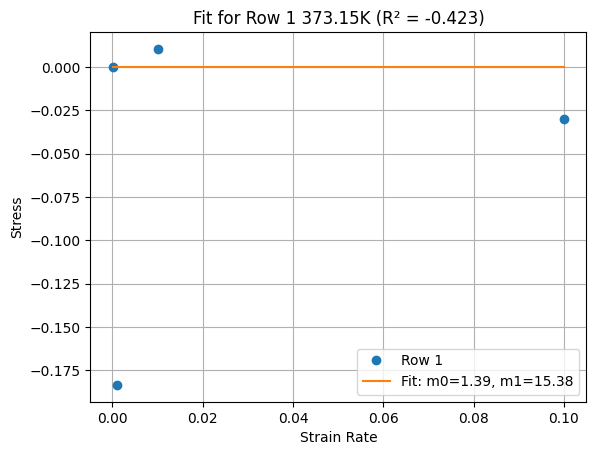

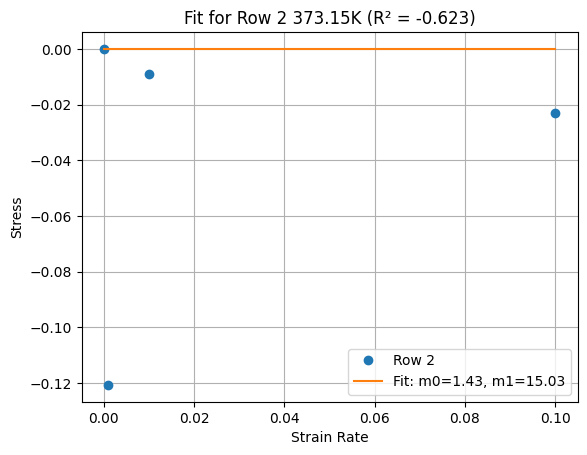

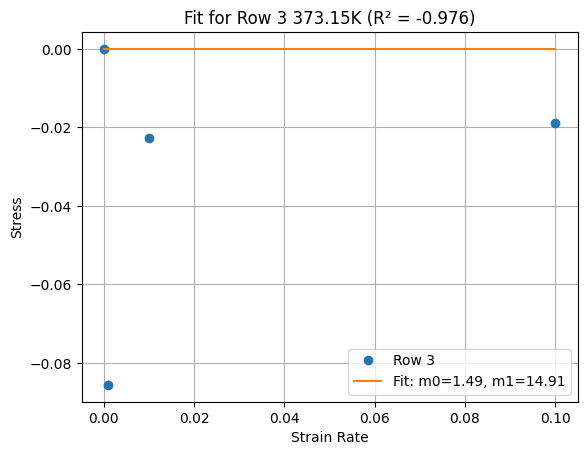

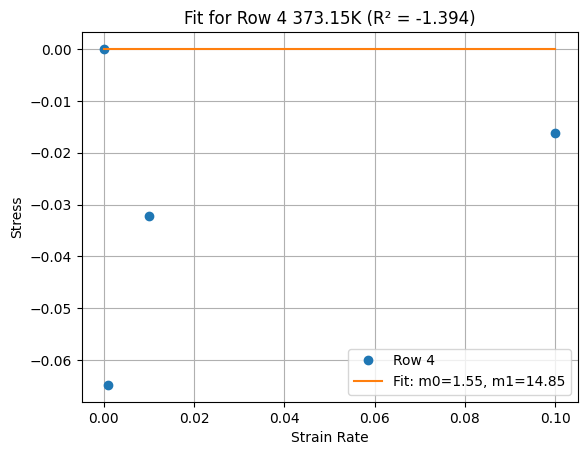

/var/folders/n_/7tqgdxqs259f7cnfxbsjqzwm0000gp/T/ipykernel_33847/2446139207.py:90: RuntimeWarning: invalid value encountered in scalar divide
  r_squared = 1 - (ss_res / ss_tot)


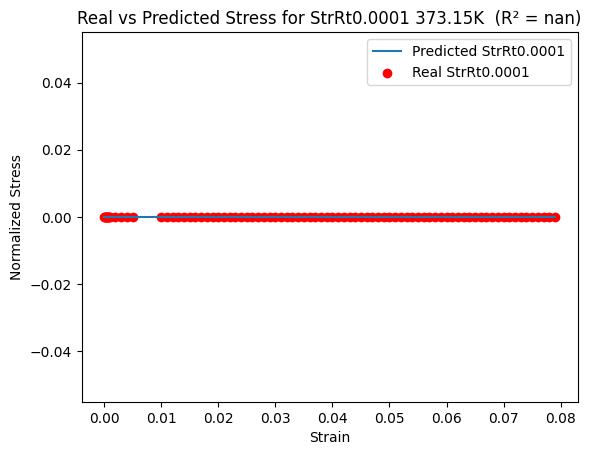

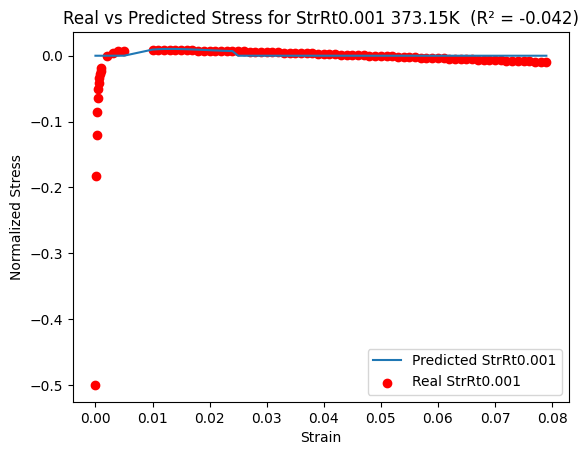

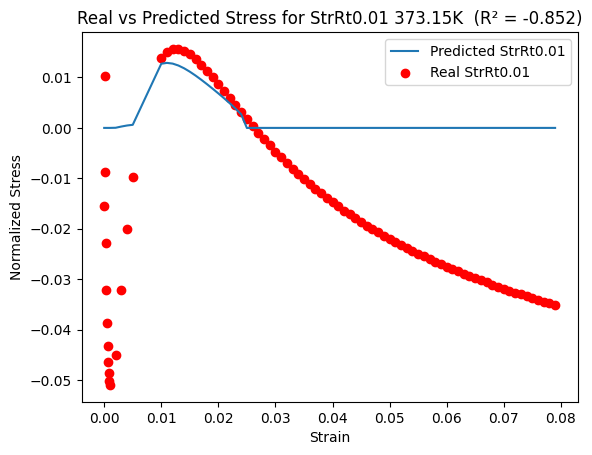

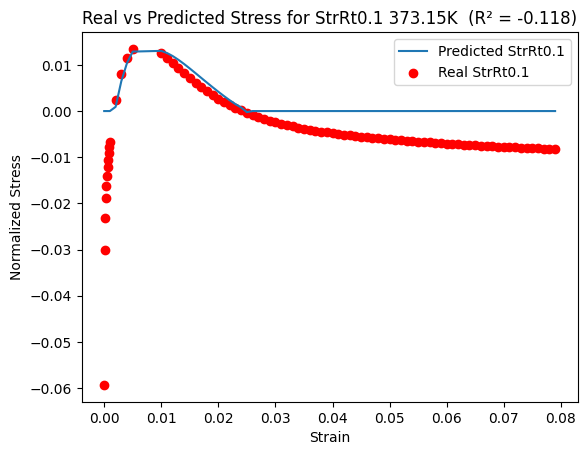

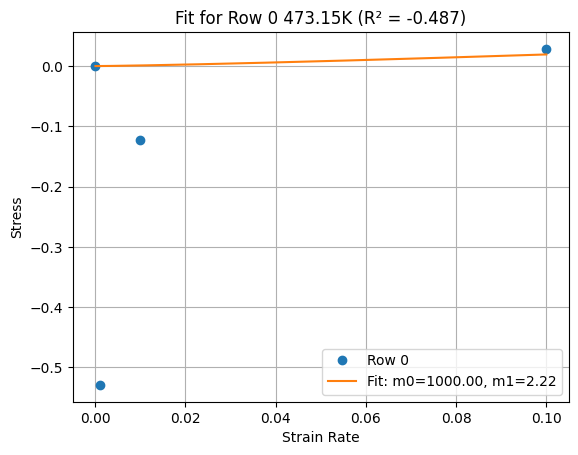

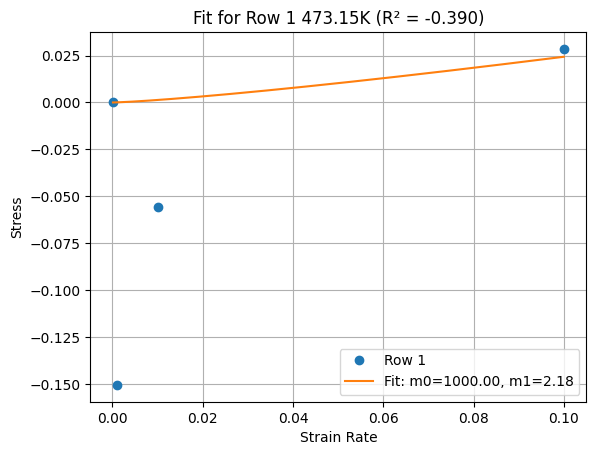

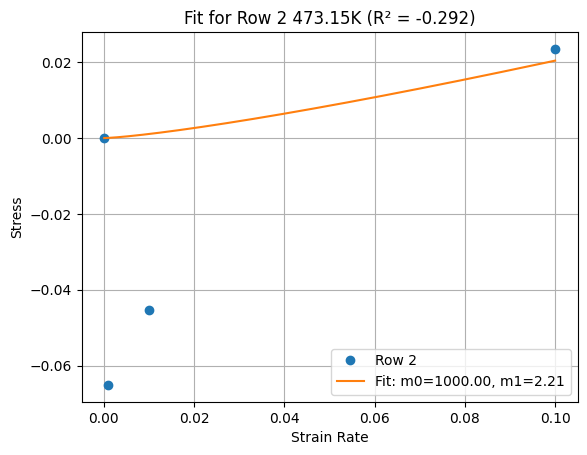

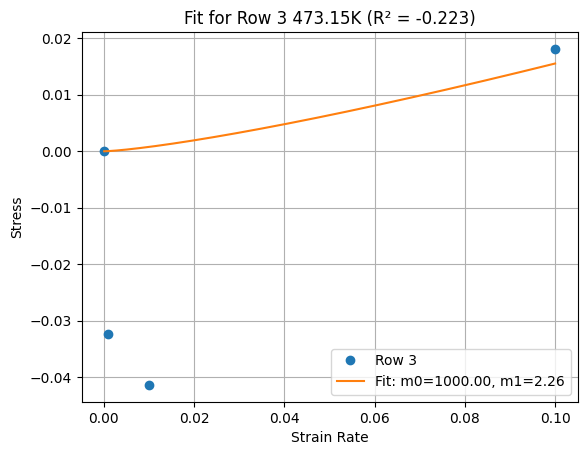

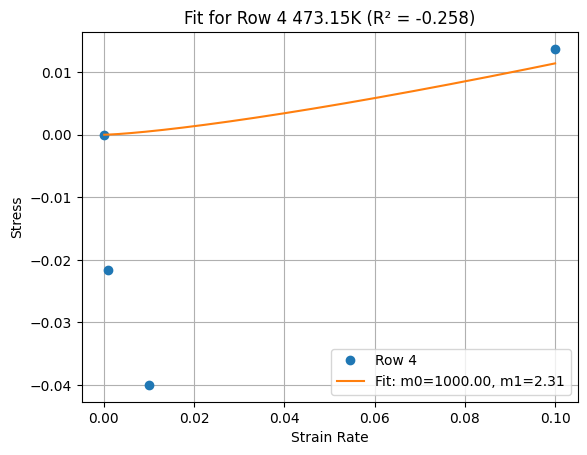

/var/folders/n_/7tqgdxqs259f7cnfxbsjqzwm0000gp/T/ipykernel_33847/2446139207.py:90: RuntimeWarning: invalid value encountered in scalar divide
  r_squared = 1 - (ss_res / ss_tot)


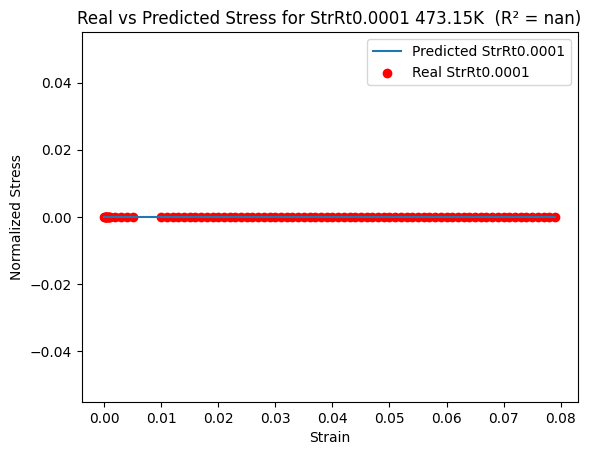

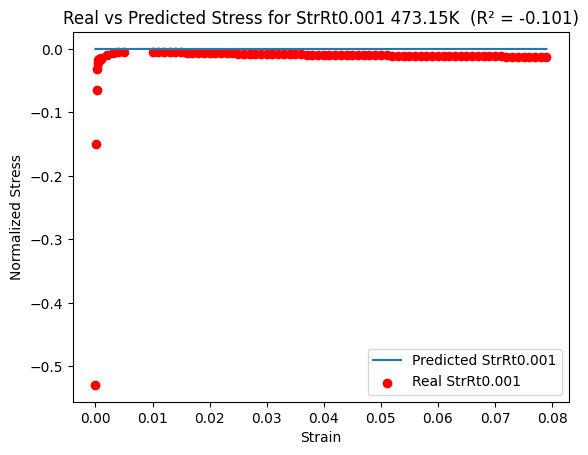

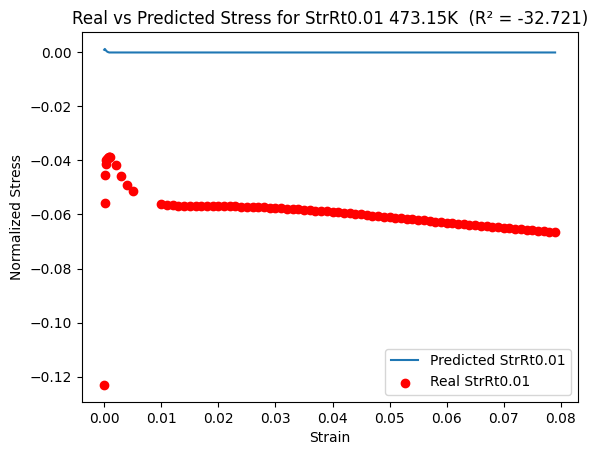

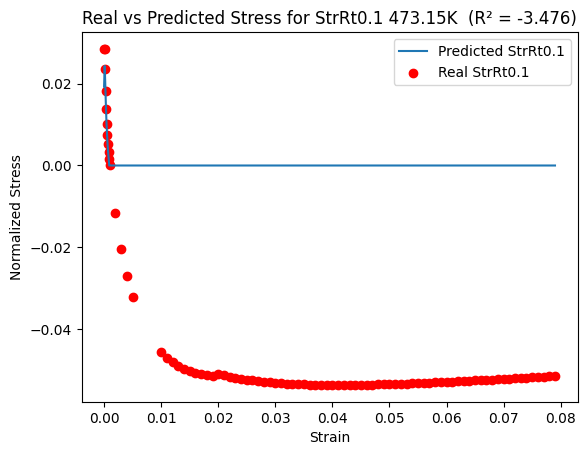

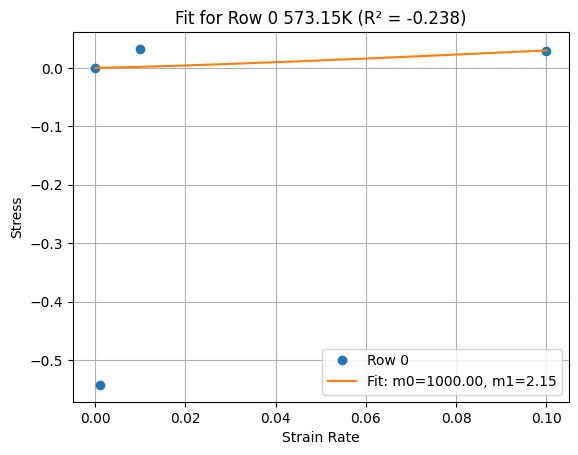

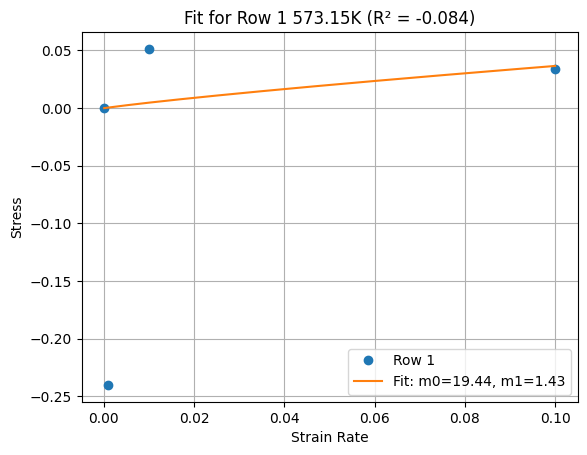

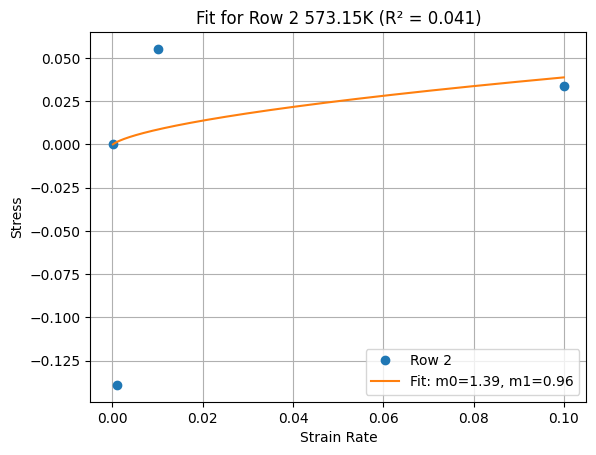

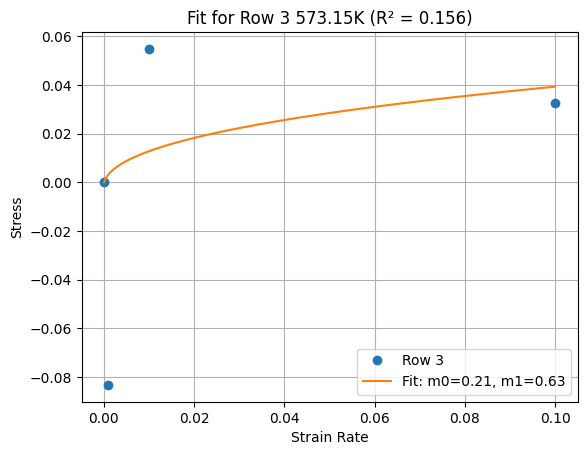

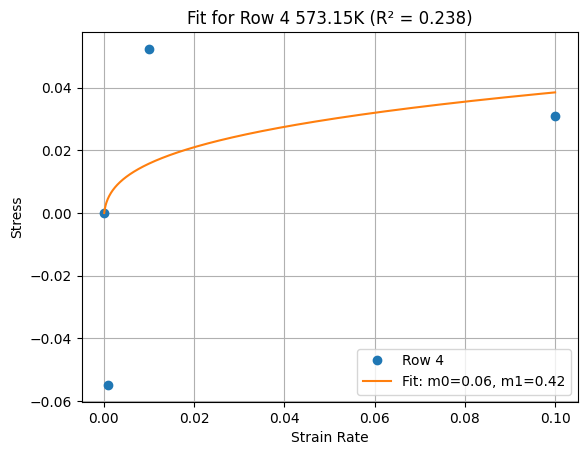

/var/folders/n_/7tqgdxqs259f7cnfxbsjqzwm0000gp/T/ipykernel_33847/2446139207.py:90: RuntimeWarning: invalid value encountered in scalar divide
  r_squared = 1 - (ss_res / ss_tot)


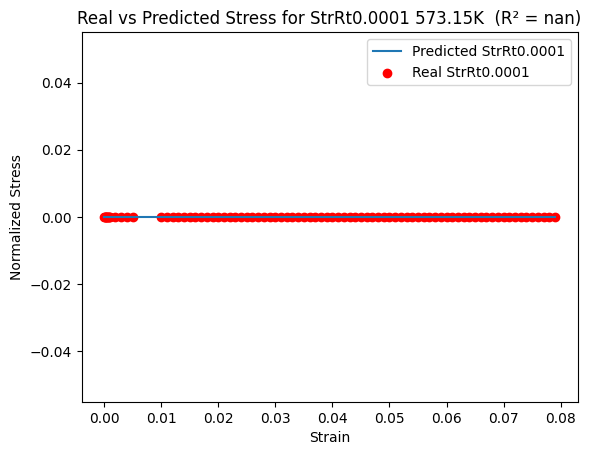

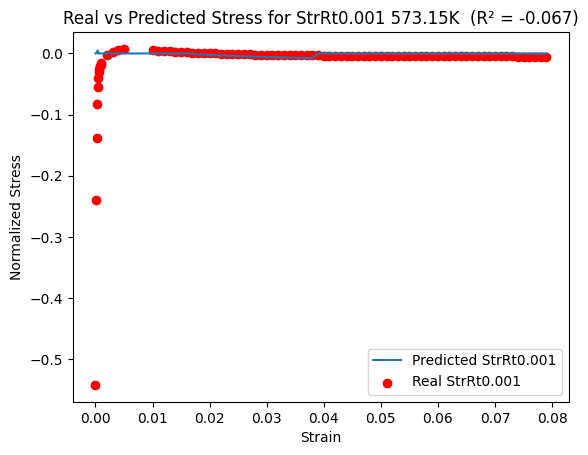

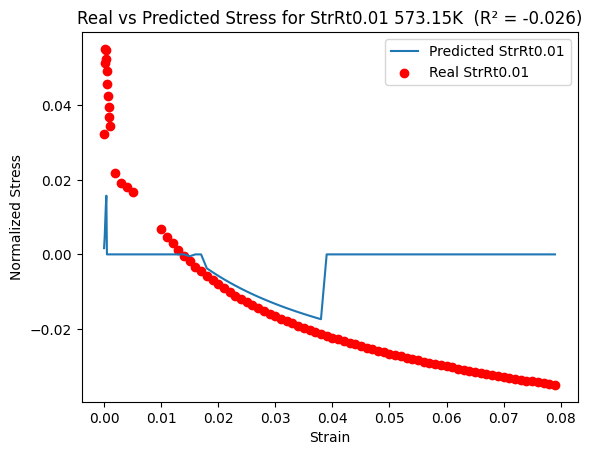

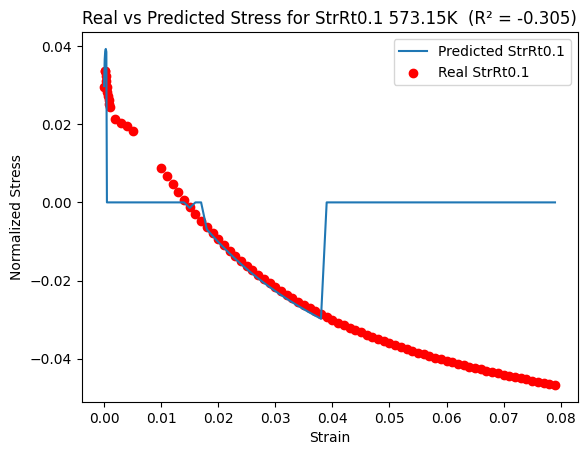

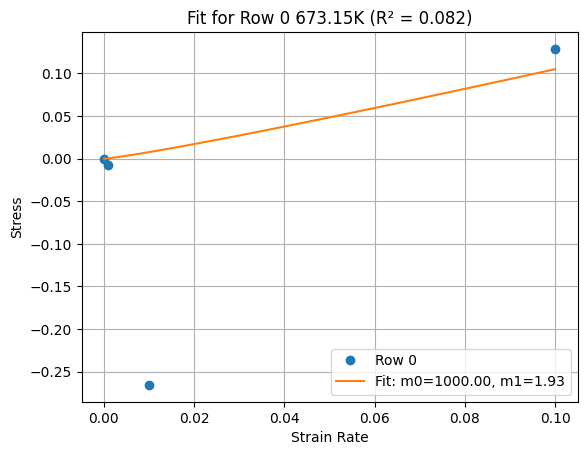

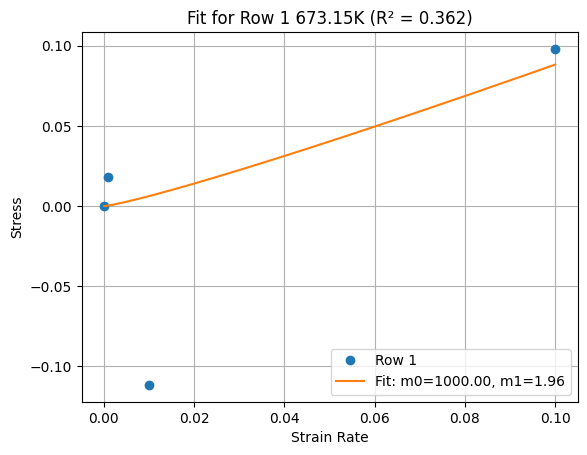

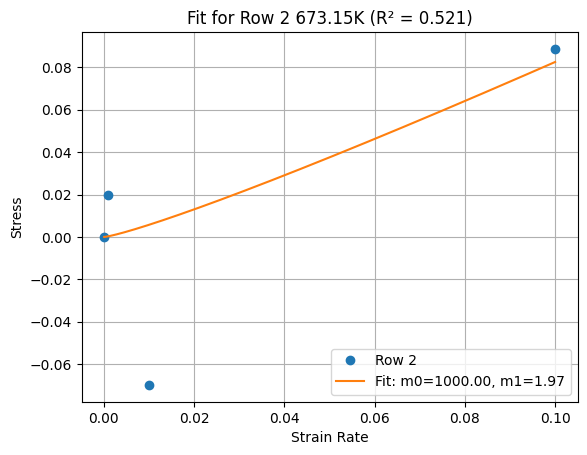

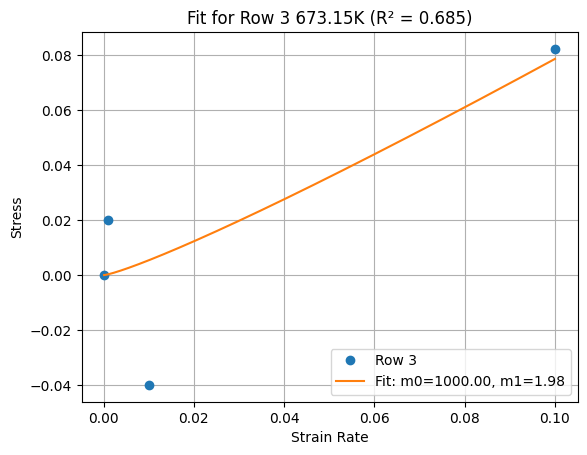

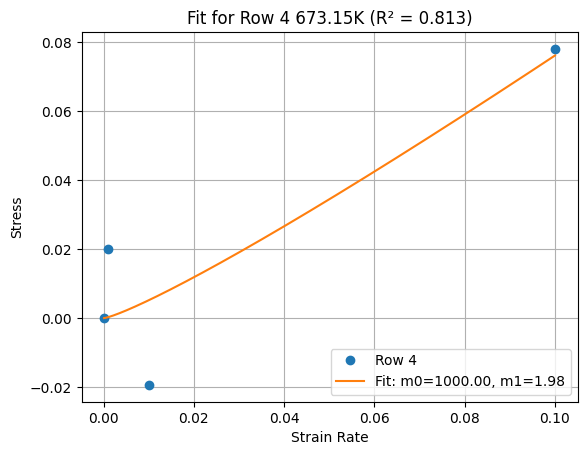

/var/folders/n_/7tqgdxqs259f7cnfxbsjqzwm0000gp/T/ipykernel_33847/2446139207.py:90: RuntimeWarning: invalid value encountered in scalar divide
  r_squared = 1 - (ss_res / ss_tot)


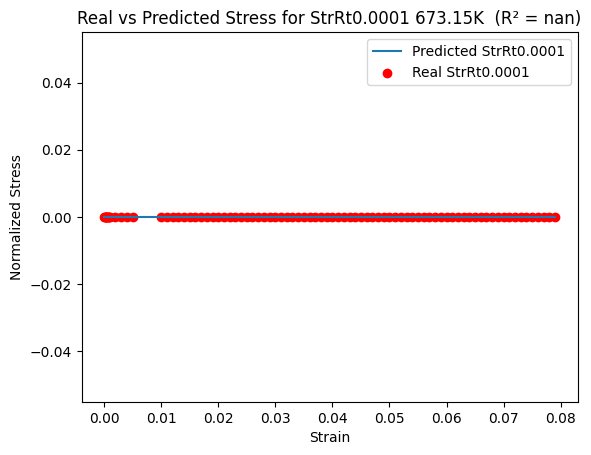

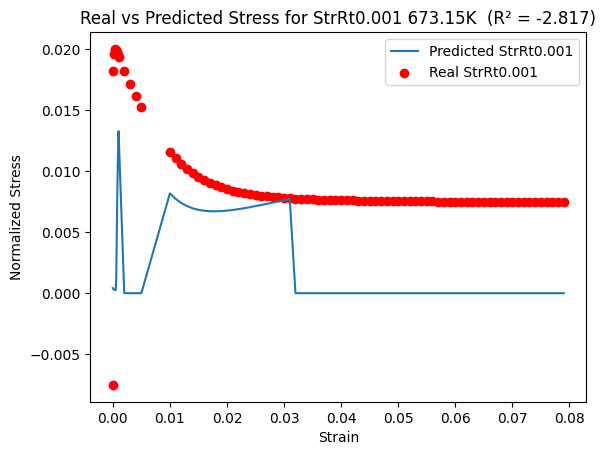

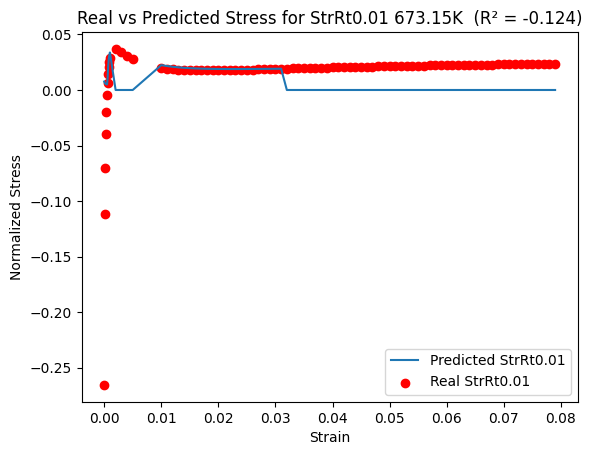

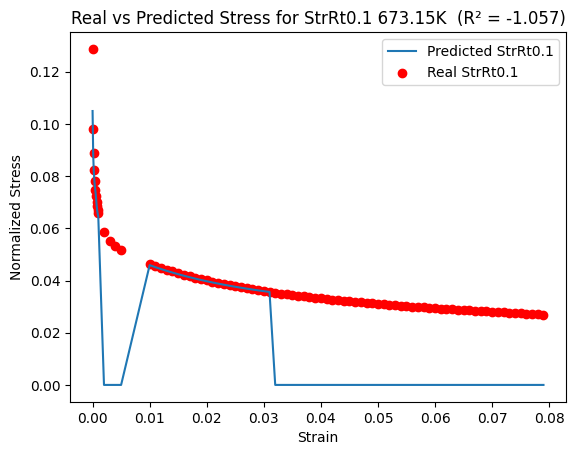

In [181]:
temp = '298.15'
strain_rates = np.array([0.0001, 0.001, 0.01, 0.1, 1])
strain_rate_columns = ['ref_StrRt0.0001', 'ref_StrRt0.001', 'ref_StrRt0.01', 'ref_StrRt0.1', 'ref_StrRt1']
data = pd.read_csv(f"../Tmp{temp}_RD.csv")
estimate_m_values(data, temp, strain_rates, strain_rate_columns)


temps = ['373.15', '473.15', '573.15', '673.15']
strain_rates = np.array([0.0001, 0.001, 0.01, 0.1])
strain_rate_columns = ['ref_StrRt0.0001', 'ref_StrRt0.001', 'ref_StrRt0.01', 'ref_StrRt0.1']

for temp in temps:
    data = pd.read_csv(f"../Tmp{temp}_RD.csv")
    estimate_m_values(data, temp, strain_rates, strain_rate_columns)


# Check quality for m0 and m1 fitting

In [182]:
temps = ['298.15', '373.15', '473.15', '573.15', '673.15']
threshold = 0.90
for temp_file in temps:
    # Load the data from the CSV file
    df = pd.read_csv(f"w_m_values_{temp_file}.csv")
    
    # Count rows where R_squared is less than the threshold
    total_rows = len(df)
    count_low_r_squared = df[df['R_squared'] < threshold].shape[0]
    
    # Calculate the percentage of rows with low R_squared
    percentage_low_r_squared = (count_low_r_squared / total_rows) * 100 if total_rows > 0 else 0
    
    # Print results
    print(f"\nTemperature File: Parameters_{temp_file}.csv")
    if count_low_r_squared > 0:
        print(f"Number of rows with R_squared < {threshold}: {count_low_r_squared}")
        print(f"Percentage of rows with R_squared < {threshold}: {percentage_low_r_squared:.2f}%")
    else:
        print(f"All R_squared values are >= {threshold}.")



Temperature File: Parameters_298.15.csv
Number of rows with R_squared < 0.9: 14
Percentage of rows with R_squared < 0.9: 16.47%

Temperature File: Parameters_373.15.csv
Number of rows with R_squared < 0.9: 79
Percentage of rows with R_squared < 0.9: 92.94%

Temperature File: Parameters_473.15.csv
Number of rows with R_squared < 0.9: 85
Percentage of rows with R_squared < 0.9: 100.00%

Temperature File: Parameters_573.15.csv
Number of rows with R_squared < 0.9: 71
Percentage of rows with R_squared < 0.9: 83.53%

Temperature File: Parameters_673.15.csv
Number of rows with R_squared < 0.9: 59
Percentage of rows with R_squared < 0.9: 69.41%


In [183]:
'''
def estimate_m_values(data, strain_rate_columns, strain_rates, temp, plot=True):
    m_values = []
    
    # Define a modified function with a scaling parameter
    def wagoner(strain_rate, m0, m1):
        return m0 * (np.sqrt(strain_rate * 0.0001) ** m1) * (np.log(strain_rate / 0.0001))

    
    stress_values = data[strain_rate_columns].values
    log_stress = np.log(stress_values)

    # Fit with an additional scaling parameter
    try:
        popt, _ = curve_fit(wagoner, strain_rates, log_stress, p0=[0.5, 0.5], maxfev=100000)
        m0, m1 = popt
    except RuntimeError as e:
        print(f"Fit did not converge for strain index {i}: {e}")
        m0, m1 = np.nan, np.nan, np.nan

    m_values.append({
        'strain': data['strain'].iloc[i],
        'm0_estimated': m0,
        'm1_estimated': m1
    })
    
    df = pd.DataFrame(m_values)
    
    if plot:
        strain = data['strain']
        for strain_rate, col in zip(strain_rates, strain_rate_columns):
            fitted_stress = [(strain_rate / 0.0001) ** (m0*(np.sqrt(strain_rate * 0.0001)**m1)) for m0, m1 in 
                             zip(df['m0_estimated'], df['m1_estimated'])]
            real_stress = data[col]
            plt.plot(strain, fitted_stress, label=f'Predicted StrRt{strain_rate}')
            plt.scatter(strain, real_stress, color='red', label=f'Real StrRt{strain_rate}')
            plt.xlabel('Strain')
            plt.ylabel('Normalized Stress')
            plt.title(f'Real vs Predicted Stress for StrRt{strain_rate} {temp}K')
            plt.legend()
            plt.show()

    #df.to_csv(f'w_m_values_{temp}.csv', index=False)
    return df
'''


'\ndef estimate_m_values(data, strain_rate_columns, strain_rates, temp, plot=True):\n    m_values = []\n    \n    # Define a modified function with a scaling parameter\n    def wagoner(strain_rate, m0, m1):\n        return m0 * (np.sqrt(strain_rate * 0.0001) ** m1) * (np.log(strain_rate / 0.0001))\n\n    \n    stress_values = data[strain_rate_columns].values\n    log_stress = np.log(stress_values)\n\n    # Fit with an additional scaling parameter\n    try:\n        popt, _ = curve_fit(wagoner, strain_rates, log_stress, p0=[0.5, 0.5], maxfev=100000)\n        m0, m1 = popt\n    except RuntimeError as e:\n        print(f"Fit did not converge for strain index {i}: {e}")\n        m0, m1 = np.nan, np.nan, np.nan\n\n    m_values.append({\n        \'strain\': data[\'strain\'].iloc[i],\n        \'m0_estimated\': m0,\n        \'m1_estimated\': m1\n    })\n    \n    df = pd.DataFrame(m_values)\n    \n    if plot:\n        strain = data[\'strain\']\n        for strain_rate, col in zip(strain_rates